In [205]:
#df_final['ur'] = df_final['ur'].apply(lambda x: (x.strip('%'))).apply(lambda x: float(x))


In [193]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
from datetime import date
from datetime import timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [194]:
def correct_slot(row):
    if (row.pa_hour <= 9):
        var = row.pa_slot.split("-")
        return ("0" + var[0] + "-" + "0" + var[1])
    return (row.pa_slot)

def generate_intersections(df_filter, df_final, country):

    rows = {'products': [], 'percentage_of_a': [], 'percentage_of_b_empty': []}

    df_final = df_final[df_final.country == country]
    df_filter = df_filter[df_filter.country == country]

    for i in range(1, 31):
        df_b = df_final[df_final.products <= i].merge(df_filter,  how='left', on='order_id') # Estan en B
        df_b = df_b[df_b.country_y.isnull()] # Estan en B pero no en A
        
        rows['products'].append(i)
        rows['percentage_of_a'].append(len(df_filter.merge(df_final[df_final.products <= i], on='order_id', how='inner'))/len(df_filter))
        rows['percentage_of_b_empty'].append(len(df_b)/len(df_final))

    df_testing = pd.DataFrame(rows)

    df_testing['diff1'] = df_testing['percentage_of_a']/df_testing['percentage_of_b_empty']
    df_testing['diff2'] = df_testing['diff1'] - df_testing['diff1'].shift()
    df_testing['diff3'] = df_testing['percentage_of_a'] - df_testing['percentage_of_b_empty']

    return df_testing


In [195]:
ur = pd.read_csv('./data/ur_world.csv')
param = pd.read_csv('./data/dispatcher_time_assignation.csv')
orders = pd.read_csv('./data/orders_info.csv')
orders_id = pd.read_csv('./data/orders_id.csv')

looker_info = pd.read_csv('./data/looker_orders_lw.csv')

In [196]:
looker_info = looker_info.rename(columns = {
    'Order Information Country': 'country',
    'Order Information Order ID': 'order_id',
    'Order Information Picking Type': 'picking_type',
    'Order Information On Demand? (Yes / No)': 'on_demand',
    'Order Information On Demand ASAP? (Yes / No)': 'asap',
    'Order Information Qty Products Ordered': 'products',
    'Order Information Promised Minutes': 'promised_min'
})

ur = ur.rename(columns={
    'Dates & Times Slot Interval': 'slot_interval',
    'Dates & Times Start Slot Time': 'start_slot',
    'Geo Information Country ID': 'country',
    'Geo Information City Code': 'city_code',
    'Geo Information Zone Name': 'zone',
    'Capacity Metrics Utilization Rate': 'ur',
    'Dates & Times Local Time Date': 'date'
})

In [197]:
ur['ur'] = ur['ur'].str.replace('%', '').astype(float)
ur['key'] = ur['date'].astype(str) + "-" + ur['zone'].astype(str) + "-" + ur['slot_interval'].astype(str)

orders['picking_assignable_time'] = pd.to_datetime(orders['picking_assignable_time'])
orders['first_assignation'] = pd.to_datetime(orders['first_assignation'])
orders['last_assignation'] = pd.to_datetime(orders['last_assignation'])
orders['picking_assignable_time_v2'] = orders['picking_assignable_time'].dt.round('T')
orders['assignable_time'] = ( orders['last_assignation'] - orders['picking_assignable_time'] ) / pd.Timedelta(minutes=1)
orders['picking_assignable_time_v2'] = orders['picking_assignable_time'].dt.round('T')
orders['pa_hour'] = orders.picking_assignable_time_v2.dt.hour
orders['pa_min'] = orders.picking_assignable_time_v2.dt.minute


In [198]:
conditions = [
    orders.picking_assignable_time_v2.dt.minute <= 19,
    (orders.picking_assignable_time_v2.dt.minute >= 20) & (orders.picking_assignable_time_v2.dt.minute <= 39),
    orders.picking_assignable_time_v2.dt.minute >= 40 
    ]

choices = [orders['pa_hour'].astype(str) + ":00" + ":00-" + orders['pa_hour'].astype(str) + ":19:59",
           orders['pa_hour'].astype(str) + ":20" + ":00-" + orders['pa_hour'].astype(str) + ":39:59",
           orders['pa_hour'].astype(str) + ":40" + ":00-" + orders['pa_hour'].astype(str) + ":59:59"]

orders['pa_slot'] = np.select(conditions, choices, default='black')
orders['pa_slot'] = orders.apply(correct_slot,axis = 1)
orders['key'] = orders['picking_assignable_time'].dt.date.astype(str) + "-" + orders['zone'].astype(str) + "-" + orders['pa_slot'].astype(str)


In [199]:
df = pd.merge(orders,ur[['key','ur']], left_on = 'key', right_on = 'key')

In [200]:
param['half_assignation'] = param['parameters']/2
df_final = pd.merge(df,param[['zona','half_assignation']], left_on = 'zone', right_on = 'zona',how = 'left')

In [203]:
# Aca defino al grupo que queremos atacar en base a UR, TFA, Rejections
df_filter = df_final[(df_final.rejected >= 1) & (df_final.ur <= 75) & (df_final.time_before_first_assignation <= 5)]

In [206]:
len(df_filter)/len(df_final)

0.15670651928716445

<AxesSubplot:xlabel='products'>

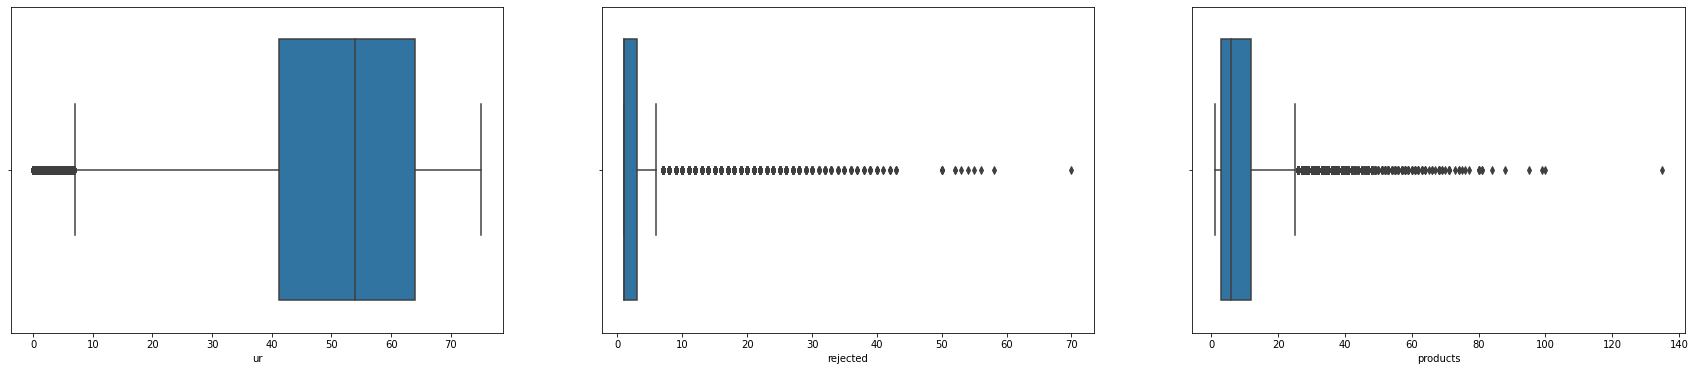

In [182]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

sns.boxplot(ax=axes[0], data=df_filter, x='ur')
sns.boxplot(ax=axes[1], data=df_filter, x='rejected')
sns.boxplot(ax=axes[2], data=df_filter, x='products')


In [184]:
rows = {'products': [], 'percentage_of_a': [], 'percentage_of_b_empty': []}



# Porcentaje de ordenes que estan en Grupo A y B
# Porcentaje de ordenes solo B
for i in range(1, 21):
    df_b = df_final[df_final.products <= i].merge(df_filter,  how='left', on='order_id') # Estan en B
    df_b = df_b[df_b.country_y.isnull()] # Estan en B pero no en A
    
    rows['products'].append(i)
    rows['percentage_of_a'].append(len(df_filter.merge(df_final[df_final.products <= i], on='order_id', how='inner'))/len(df_filter))
    rows['percentage_of_b_empty'].append(len(df_b)/len(df_final))

df_testing = pd.DataFrame(rows)

df_testing['diff'] = df_testing['percentage_of_a']/df_testing['percentage_of_b_empty']
df_testing['diff2'] = df_testing['percentage_of_a'] - df_testing['percentage_of_b_empty']
df_testing['diff3'] = df_testing['diff'] - df_testing['diff'].shift()


In [186]:
df_testing

,products,percentage_of_a,percentage_of_b_empty,diff,diff2,diff3
0,1,0.133824,0.114309,1.170716,0.019514,NaN
1,2,0.232171,0.187798,1.236282,0.044373,0.065566
2,3,0.314859,0.243212,1.294586,0.071647,0.058304
3,4,0.388883,0.289125,1.345031,0.099757,0.050445
4,5,0.451680,0.328286,1.375873,0.123394,0.030842
5,6,0.509755,0.364530,1.398390,0.145225,0.022517
6,7,0.562325,0.397299,1.415370,0.165026,0.016980
7,8,0.614514,0.429807,1.429745,0.184707,0.014375
8,9,0.661980,0.460603,1.437203,0.201377,0.007458
9,10,0.705177,0.488921,1.442313,0.216256,0.005110


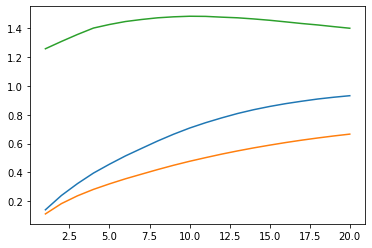

In [166]:
plt.plot(df_testing['products'], df_testing['percentage_of_a'])
plt.plot(df_testing['products'], df_testing['percentage_of_b_empty'])
plt.plot(df_testing['products'], df_testing['diff'])

BR

In [23]:
br_filter = df_filter[df_filter.country == 'BR']
br_total = df_final[df_final.country == 'BR']

In [114]:
looker_br = looker_info[looker_info.country == 'BR']
looker_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79927 entries, 20 to 464297
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       79927 non-null  object 
 1   order_id      79927 non-null  int64  
 2   picking_type  79926 non-null  object 
 3   on_demand     79927 non-null  object 
 4   asap          79927 non-null  object 
 5   products      79927 non-null  int64  
 6   promised_min  79926 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 4.9+ MB


In [117]:
br_filter = pd.merge(br_filter,looker_br[['order_id','picking_type','on_demand','asap','promised_min']], left_on = 'order_id', right_on = 'order_id')

In [118]:
len(br_filter)/ len(br_total)

0.4115368609750632

In [119]:
br_filter['products'].describe()

count    25712.000000
mean         8.748211
std          8.076936
min          1.000000
25%          3.000000
50%          7.000000
75%         12.000000
max         99.000000
Name: products, dtype: float64

<AxesSubplot:>

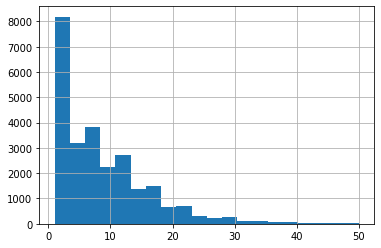

In [120]:
br_filter[br_filter.products <= 50]['products'].hist(bins = 20)

In [121]:
br_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25712 entries, 0 to 25711
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       25712 non-null  int64         
 1   country                        25712 non-null  object        
 2   city                           25712 non-null  object        
 3   zone                           25712 non-null  object        
 4   products                       25712 non-null  int64         
 5   rejected                       25712 non-null  int64         
 6   rejected_expired               25712 non-null  int64         
 7   assignations                   25712 non-null  int64         
 8   lateness                       25712 non-null  float64       
 9   delivery_result                25712 non-null  object        
 10  picking_assignable_time        25712 non-null  datetime64[ns]
 11  first_assignati

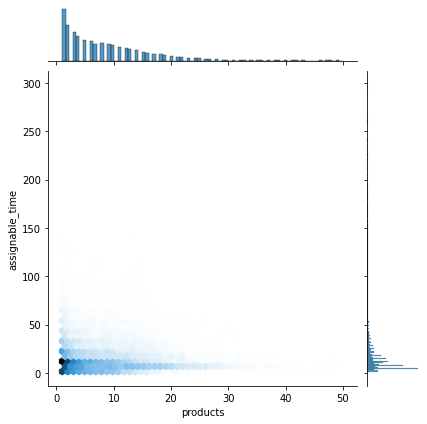

In [122]:
sns.jointplot(data = br_filter[br_filter.products <= 50], x = 'products', y = 'assignable_time'
             ,kind = 'hex')

<AxesSubplot:xlabel='products'>

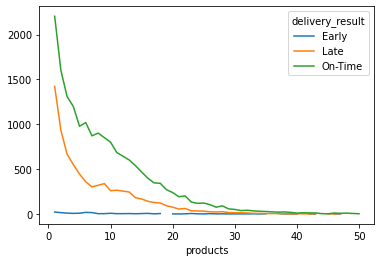

In [123]:
pd.pivot_table(data = br_filter[br_filter.products <= 50]
               , index = 'products'
               , columns = 'delivery_result'
               , values = 'order_id'
               , aggfunc = 'count').plot()

In [124]:
at = pd.pivot_table(data = br_filter
               , index = 'products'
               , columns = 'delivery_result'
               , values = 'assignable_time'
               , aggfunc = np.mean).reset_index().fillna(0)
at

delivery_result,products,Early,Late,On-Time
0,1,10.224163,31.099682,12.657044
1,2,11.503350,29.560458,12.636857
2,3,7.090661,30.319856,12.024903
3,4,10.981607,31.735710,12.383820
4,5,9.059806,30.730846,12.088325
...,...,...,...,...
70,75,0.000000,0.000000,3.983620
71,80,10.680519,0.000000,0.000000
72,81,0.000000,5.080603,0.000000
73,84,0.000000,0.000000,6.457836


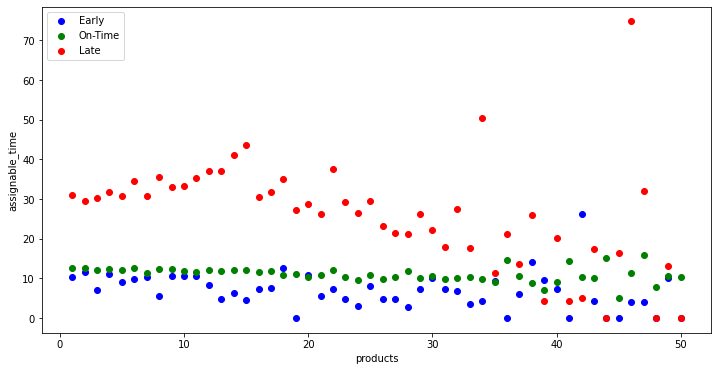

In [125]:
plt.figure(figsize=(12,6))

at_plot = at[at.products <= 50]

plt.scatter(at_plot['products'],at_plot['Early'], label = 'Early', color = 'b')
plt.scatter(at_plot['products'],at_plot['On-Time'], label = 'On-Time', color = 'g')
plt.scatter(at_plot['products'],at_plot['Late'], label = 'Late', color = 'r')

plt.xlabel('products')
plt.ylabel('assignable_time')

plt.legend()

plt.show()

In [138]:
assign = pd.pivot_table(
                data = br_filter
               , index = 'assignations'
               , columns = 'delivery_result'
               , values = 'assignable_time'
               , aggfunc = np.mean).reset_index().fillna(0)

<AxesSubplot:xlabel='assignations'>

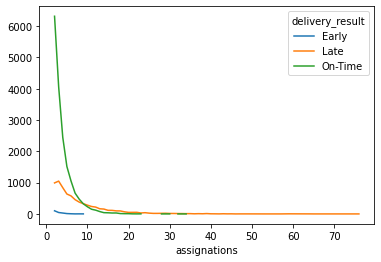

In [139]:
pd.pivot_table(data = br_filter
               , index = 'assignations'
               , columns = 'delivery_result'
               , values = 'order_id'
               , aggfunc = 'count').plot(kind = 'line')

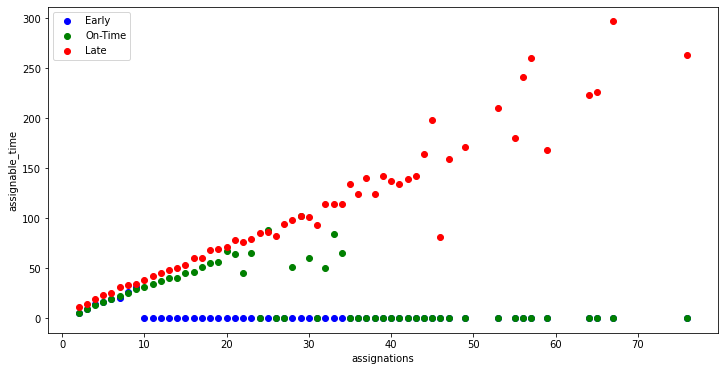

In [140]:
plt.figure(figsize=(12,6))

assign_plot = assign[assign.assignations <= 20000]

plt.scatter(assign_plot['assignations'],assign_plot['Early'], label = 'Early', color = 'b')
plt.scatter(assign_plot['assignations'],assign_plot['On-Time'], label = 'On-Time', color = 'g')
plt.scatter(assign_plot['assignations'],assign_plot['Late'], label = 'Late', color = 'r')

plt.xlabel('assignations')
plt.ylabel('assignable_time')

plt.legend()

plt.show()

In [141]:
br_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25098 entries, 0 to 25711
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       25098 non-null  int64         
 1   country                        25098 non-null  object        
 2   city                           25098 non-null  object        
 3   zone                           25098 non-null  object        
 4   products                       25098 non-null  int64         
 5   rejected                       25098 non-null  int64         
 6   rejected_expired               25098 non-null  int64         
 7   assignations                   25098 non-null  int64         
 8   lateness                       25098 non-null  float64       
 9   delivery_result                25098 non-null  object        
 10  picking_assignable_time        25098 non-null  datetime64[ns]
 11  first_assignati

In [142]:
br_filter = br_filter[br_filter['picking_type'] == 'Picker-Driver'] #Use only single orders

<AxesSubplot:xlabel='products'>

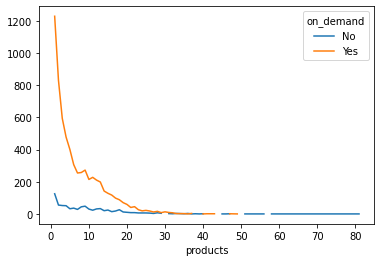

In [152]:
pd.pivot_table(data = br_filter[br_filter.delivery_result == 'Late']
              , index = 'products'
              , columns = 'on_demand'
              , values = 'assignable_time'
              , aggfunc = 'count'
              ).plot()